
# Carga de librerias


In [641]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict, KFold
from sklearn.metrics import roc_curve, auc
from collections import Counter
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

# Funciones
* Clase  ```SBS``` para la seleccipon de caracteristicas

In [583]:
from sklearn.base import clone
from itertools import combinations, permutations
class SBS():
  def __init__(self, estimator, k_features,
               scoring=auc,test_size=0.25, random_state=1):
    self.scoring = scoring
    self.estimator = clone(estimator)
    self.k_features = k_features
    self.test_size = test_size
    self.random_state = random_state

  def fit(self, X, y):
    X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=self.test_size,
    random_state=self.random_state)
    dim = X_train.shape[1]
    self.indices_ = [i for i in range(dim)]
    self.subsets_ = [self.indices_]
    score = self._calc_score(X_train, y_train,
                             X_test, y_test, self.indices_)
    self.scores_ = [score]
    while dim > self.k_features:
      scores = []
      subsets = []
      for p in combinations(self.indices_, r=dim-1):
        score = self._calc_score(X_train, y_train,X_test, y_test, list(p))
        scores.append(score)
        subsets.append(p)
      best = np.argmax(scores)
      self.indices_ = subsets[best]
      self.subsets_.append(self.indices_)
      dim -= 1

      self.scores_.append(scores[best])

    self.k_score_ = self.scores_[-1]

    return self

  def transform(self, X):
    return X.iloc[:, self.indices_]

  #def _calc_score(self, X_train, y_train,X_test, y_test, indices):
   # self.estimator.fit(X_train.iloc[:, indices], y_train)
    #y_pred = self.estimator.predict(X_test.iloc[:, indices])
    #score = self.scoring(y_test, y_pred)
    #return score
  def _calc_score(self, X_train, y_train,X_test, y_test, indices):
    #self.estimator.fit(X_train.iloc[:, indices], y_train)
    #y_pred = self.estimator.predict(X_test.iloc[:, indices])
    #score = self.scoring(y_test, y_pred)
    y_pred = self.estimator.fit(X_train.iloc[:, indices], y_train).predict_proba(X_test.iloc[:, indices])[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)    
    return roc_auc

# Carga de datos

In [347]:
train = pd.read_csv('C:/Users/57314/Downloads/Base_entrenamiento.csv')
test = pd.read_csv('C:/Users/57314/Downloads/Base_prueba.csv')

## Eliminación de variables:
* Puesto que las variables que poseen un único valor no brindan información relevante, las elimino del conjunto de datos.
* Elimino la variable ```llave```. 
* Elimino variables cuya varianza es poco significativa.

In [348]:
llave_test = test['llave']
llave_test

0         1
1         3
2         4
3         6
4         7
       ... 
995    2019
996    2021
997    2025
998    2027
999    2028
Name: llave, Length: 1000, dtype: int64

In [349]:
drop_val = [i for i in train.columns if train[i].nunique() == 1]
drop_val += ['llave']
train.drop(drop_val,1, inplace=True)
test.drop(drop_val,1, inplace=True)

In [350]:
train.var().sort_values(ascending=False).tail(10)

pc_cantidad_tdc_entidad       0.079263
pcons_vehiculos_sufi          0.055963
pcons_hipotecario_vivienda    0.036512
gsm_mejor_gestion             0.025599
gsm_mejor_gestion_3m          0.025599
dc_porc_prod_sin_mora         0.015307
nro_gestiones                 0.004198
gsm_prom_dias_gest            0.003250
gestiones_eficaces            0.001649
gestiones_prod                0.001100
dtype: float64

In [351]:
val_drop_var = ['nro_gestiones','gsm_prom_dias_gest','gestiones_eficaces','gestiones_prod']
train.drop(val_drop_var,1, inplace=True)
test.drop(val_drop_var,1, inplace=True)

In [352]:
print("train: \n",train.var().sort_values(ascending=False).tail() )
print("")
print("test: \n",test.var().sort_values(ascending=False).tail())

train: 
 pcons_vehiculos_sufi          0.055963
pcons_hipotecario_vivienda    0.036512
gsm_mejor_gestion_3m          0.025599
gsm_mejor_gestion             0.025599
dc_porc_prod_sin_mora         0.015307
dtype: float64

test: 
 pc_peor_estado_act_cta_aho    0.048688
pcons_hipotecario_vivienda    0.029129
pc_cantidad_tdc_entidad       0.009974
dc_porc_prod_sin_mora         0.009910
pc_cont_30_lt_12m_tot_sf      0.000000
dtype: float64


#### Obs:
* Después de eliminar las variables en ```train``` con varianza muy próximas a cero, observo que en ```test``` aún se encuentran variables inclusive con varianza cero.
* Esto influye en la predicción de classificación.

In [353]:
train.shape, test.shape

((20000, 104), (1000, 103))

# EDA (Análisis exploratorio de los datos)

In [356]:
print("N° de filas:", train.shape[0])
print("N° de columnas:", train.shape[1])

N° de filas: 20000
N° de columnas: 104


In [357]:
train.head()

,max_trim,max_sem,desv_sem,prom_bim,max_mes_anterior,prom_mes_anterior,prom_sem,max_bim,mejor_gestion,prom_trim,...,dh_val_pago_tarj_d,pc_productos_no_rotativos_entidad,pc_saldo_no_rot_ent,pc_vi_no_rotativos_entidad,dh_min_dia_entradas,pcons_hipotecario_vivienda,gsm_mejor_gestion_3m,dh_avg_dia_salidas,y_auto_cura,anhomes_ciclo
0,7,7,2.857738,3.5,7,7.0,1.166667,7,0,2.333333,...,0,0.0,0.0,0.0,0,0,0,0.000000,0,201608
1,17,17,7.641989,12.0,17,17.0,8.000000,17,0,13.666667,...,0,0.0,0.0,0.0,2,0,0,8.810053,0,201611
2,27,36,12.868566,13.5,27,27.0,21.000000,27,0,14.000000,...,0,0.0,0.0,0.0,7,0,0,10.500000,0,201705
3,27,27,10.888832,13.5,27,27.0,4.833333,27,0,9.000000,...,0,0.0,0.0,0.0,0,0,0,0.000000,0,201609
4,32,32,11.651895,10.0,20,20.0,20.833333,20,0,17.333333,...,0,0.0,0.0,0.0,19,0,0,9.190000,0,201702


### Distribucion de las variables en ```train``` y ```test```

In [358]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(8,13,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(13,8,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show()

<Figure size 432x288 with 0 Axes>

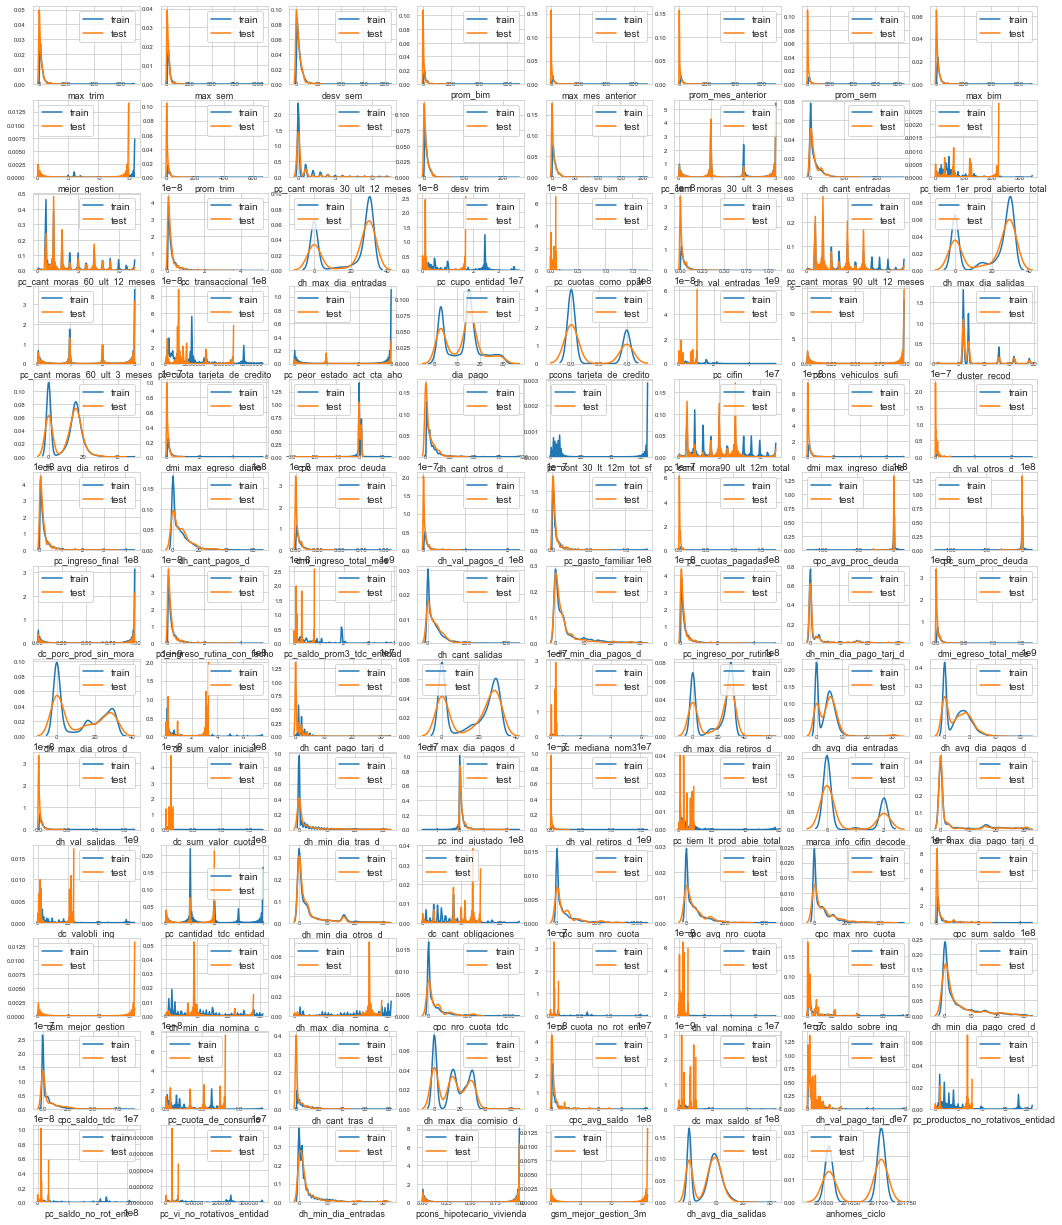

In [359]:
features = test.columns.values
plot_feature_distribution(train, test, 'train', 'test', features)

### Perspectiva:
* En algunas (mayoría) de las variables, las distribuciones no son semejantes, por ejemplo  ```dh_avg_dia_entradas```, ```pc_tiem_1er_prod_abierto_total``` entre otras mas.


### Análisis máximo días de mora por periodos de tiempo

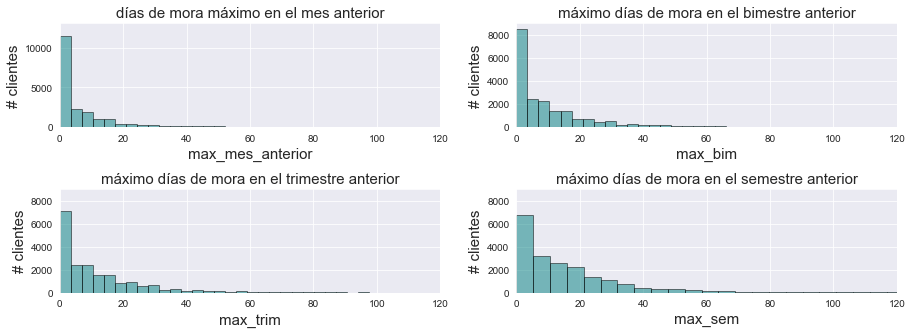

In [360]:
sns.set_style('darkgrid')
fig = plt.figure(figsize = (15,8))
fig.subplots_adjust(hspace = .60)
ax1 = fig.add_subplot(321)
ax1.hist(train['max_mes_anterior'], bins = 200, alpha = .50,edgecolor= 'black',color ='teal')
ax1.set(xlim=(0, 120), ylim=(0, train['max_mes_anterior'].value_counts().max()+3000))
ax1.set_xlabel('max_mes_anterior', fontsize = 15)
ax1.set_ylabel('# clientes',fontsize = 15)
ax1.set_title('días de mora máximo en el mes anterior',fontsize = 15)

ax2 = fig.add_subplot(322)
ax2.hist(train['max_bim'], bins = 200, alpha = .50,edgecolor= 'black',color ='teal')
ax2.set(xlim=(0, 120), ylim=(0, 9000))
ax2.set_xlabel('max_bim',fontsize = 15)
ax2.set_ylabel('# clientes',fontsize = 15)
ax2.set_title('máximo días de mora en el bimestre anterior',fontsize = 15)

ax3 = fig.add_subplot(323)
ax3.hist(train['max_trim'], bins = 200, alpha = .50,edgecolor= 'black',color ='teal')
ax3.set(xlim=(0, 120), ylim=(0, 9000))
ax3.set_xlabel('max_trim',fontsize = 15)
ax3.set_ylabel('# clientes',fontsize = 15)
ax3.set_title('máximo días de mora en el trimestre anterior',fontsize = 15)

ax4 = fig.add_subplot(324)
ax4.hist(train['max_sem'], bins = 200, alpha = .50,edgecolor= 'black',color ='teal')
ax4.set(xlim=(0, 120), ylim=(0, 9000))
ax4.set_xlabel('max_sem',fontsize = 15)
ax4.set_ylabel('# clientes',fontsize = 15)
ax4.set_title('máximo días de mora en el semestre anterior',fontsize = 15)
plt.show()

#### Se observa:

* Como se observa, estas distribuciones son muy semejantes, pienso que es por la relación de morosos entre estos periodos de tiempo; es decir, un cliente que esté en mora el mes anterior posiblemente lo estará en el bimestre anterior y con gran certeza en el trimestre anterior.

* Estas varibles están fuertemente correlaciondas.

## Variable objetivo
* ```y_auto_cura``` es nuestro objetivo, ya que esa es la variable dependiente que estamos tratando de predecir.



Variable objetivo
1    13848
0     6152
Name: y_auto_cura, dtype: int64


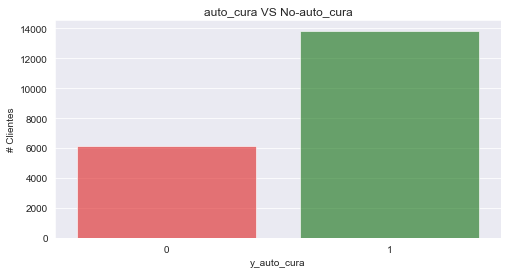

In [361]:
print('Variable objetivo')
print(train['y_auto_cura'].value_counts())
sns.set_style('darkgrid')
plt.figure(figsize = (8,4))
sns.countplot(train['y_auto_cura'], alpha =.60, palette= ['red','green'])
plt.title('auto_cura VS No-auto_cura')
plt.ylabel('# Clientes')
plt.show()

In [362]:
print("Hay {}% de valores y_auto_cura con 1".format(100 * train["y_auto_cura"].value_counts()[1]/train.shape[0]))

Hay 69.24% de valores y_auto_cura con 1


#### Perspectiva variable ```y_auto_cura```

* La mayoría de los clientes se auto_curan.
* Las clases están con desbalanceo.

### Análiziso el  ```y_auto_cura``` VS otras variables


<Figure size 432x288 with 0 Axes>

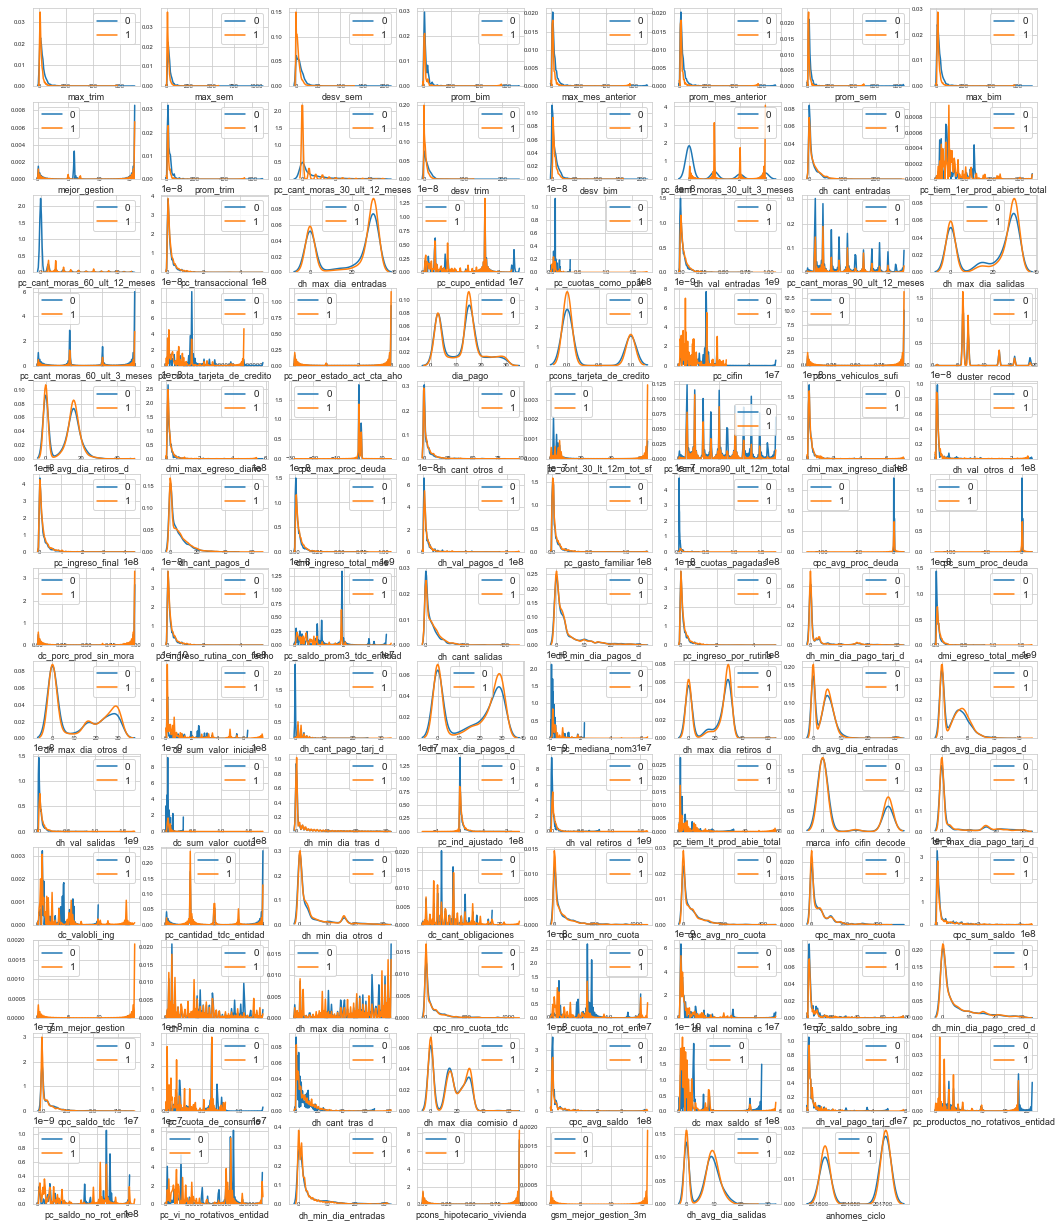

In [363]:
t_0 = train.loc[train["y_auto_cura"] == 0]
t_1 = train.loc[train["y_auto_cura"] == 1]
features = test.columns.values
plot_feature_distribution(t_0, t_1, '0', '1',features)

* Gran parte de las distribuciones  son semejenates.

PRODUCTO HIPOTECARIO:
y_auto_cura                    0      1
pcons_hipotecario_vivienda             
0                           5940  13301
1                            212    547


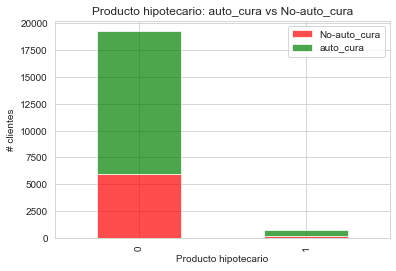

In [364]:
print('PRODUCTO HIPOTECARIO:')
print(train.groupby(['pcons_hipotecario_vivienda','y_auto_cura']).y_auto_cura.count().unstack())
hip_class = train.groupby(['pcons_hipotecario_vivienda','y_auto_cura']).y_auto_cura.count().unstack()
p1 = hip_class.plot(kind = 'bar', stacked = True, 
                   title = 'Producto hipotecario: auto_cura vs No-auto_cura', 
                   color = ['red','green'], alpha = .70)
p1.set_xlabel('Producto hipotecario')
p1.set_ylabel('# clientes')
p1.legend(['No-auto_cura','auto_cura'])
plt.show()

#### Perspectiva

* La mayoría de los clientes que no tienen un credito hipotecario se auto_curan.
* Aproximadamente el doble de los clientes que si tienen un credito hipotecario se auto_curan con respecto a los No-auto_cura.
* No se presenta un consumo considerable de este producto.

* #### ```y_auto_cura``` VS ```pcons_tarjeta_de_credito```.

TARJETA DE CREDITO:
y_auto_cura                  0     1
pcons_tarjeta_de_credito            
0                         4026  9734
1                         2126  4114


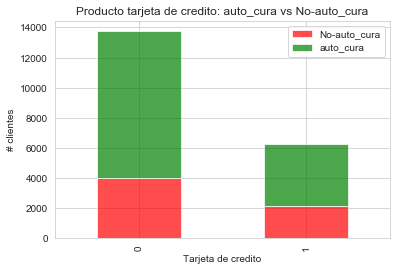

In [365]:
print('TARJETA DE CREDITO:')
print(train.groupby(['pcons_tarjeta_de_credito','y_auto_cura']).y_auto_cura.count().unstack())
cred_class = train.groupby(['pcons_tarjeta_de_credito','y_auto_cura']).y_auto_cura.count().unstack()
p1 = cred_class.plot(kind = 'bar', stacked = True, 
                   title = 'Producto tarjeta de credito: auto_cura vs No-auto_cura', 
                   color = ['red','green'], alpha = .70)
p1.set_xlabel('Tarjeta de credito')
p1.set_ylabel('# clientes')
p1.legend(['No-auto_cura','auto_cura'])
plt.show()

#### PERSPECTIVA:

* La mayoría de los clientes que no tienen una tarjeta de credito se auto_curan.
* Aproximadamente una tercera parte de los clientes que si tienen una tarjeta de credito no se auto curan.
* Se presenta un consumo considerable del producto.

* #### ```y_auto_cura``` VS ```pcons_vehiculos_sufi```.

VEHICULO SUFI:
y_auto_cura              0      1
pcons_vehiculos_sufi             
0                     5855  12955
1                      297    893


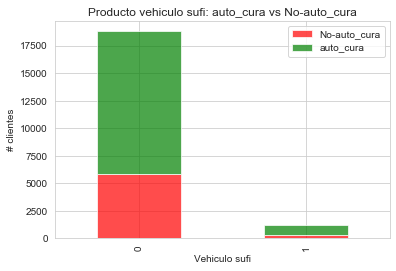

In [366]:
print('VEHICULO SUFI:')
print(train.groupby(['pcons_vehiculos_sufi','y_auto_cura']).y_auto_cura.count().unstack())
sufi_class = train.groupby(['pcons_vehiculos_sufi','y_auto_cura']).y_auto_cura.count().unstack()
p1 = sufi_class.plot(kind = 'bar', stacked = True, 
                   title = 'Producto vehiculo sufi: auto_cura vs No-auto_cura', 
                   color = ['red','green'], alpha = .70)
p1.set_xlabel('Vehiculo sufi')
p1.set_ylabel('# clientes')
p1.legend(['No-auto_cura','auto_cura'])
plt.show()

#### PERSPECTIVA:

* Esta variable presenta una distribución analoga a la variable ```pcons_hipotecario_vivienda```.

CICLO DE FACTURACIÓN:
y_auto_cura        0       1
anhomes_ciclo               
201607         417.0   969.0
201608         393.0   951.0
201609         385.0  1058.0
201610         443.0   914.0
201611         460.0   979.0
201612         415.0  1198.0
201701         485.0   926.0
201702         503.0   992.0
201703         518.0  1081.0
201704         586.0  1043.0
201705         562.0  1014.0
201706         626.0  1336.0
201707         359.0  1143.0
201708           NaN   244.0


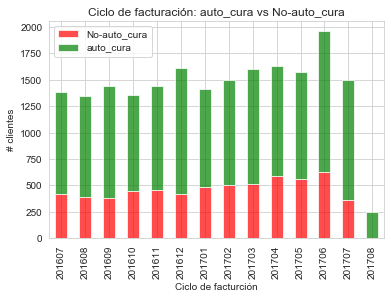

In [367]:
print('CICLO DE FACTURACIÓN:')
print(train.groupby(['anhomes_ciclo','y_auto_cura']).y_auto_cura.count().unstack())
cic_class = train.groupby(['anhomes_ciclo','y_auto_cura']).y_auto_cura.count().unstack()
p1 = cic_class.plot(kind = 'bar', stacked = True, 
                   title = 'Ciclo de facturación: auto_cura vs No-auto_cura', 
                   color = ['red','green'], alpha = .70)
p1.set_xlabel('Ciclo de facturción')
p1.set_ylabel('# clientes')
p1.legend(['No-auto_cura','auto_cura'])
plt.show()

#### PERSPECTIVA:

* Desde Julio de 2006 hasta junio de 2017 la tendencia de los clientes NO-auto_cura es creciente.
* Despues de junio de 2017 baja considerabemete el numero de clientes NO-auto_cura.
* Es evidente la falta de datos en Agosto de 2018.

In [368]:
zs = train[train['dc_cant_obligaciones']!=0]

CANTIDAD DE OBLIGACIONES :
y_auto_cura              0     1
dc_cant_obligaciones            
1                      4.0  14.0
2                      2.0   8.0
3                      4.0  30.0
4                      7.0  33.0
5                     17.0  22.0
6                      4.0  20.0
7                      3.0  11.0
8                     20.0  45.0
9                      1.0  10.0
10                     3.0   6.0
11                     9.0   7.0
12                     2.0   NaN
13                     3.0  10.0
14                     2.0   2.0
15                     NaN   5.0
17                     1.0   3.0
18                     2.0   6.0
20                     NaN   1.0
21                     NaN   2.0
25                     NaN   1.0


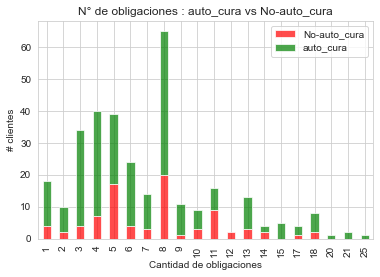

In [369]:
print('CANTIDAD DE OBLIGACIONES :')
print(zs.groupby(['dc_cant_obligaciones','y_auto_cura']).y_auto_cura.count().unstack())
cic_class = zs.groupby(['dc_cant_obligaciones','y_auto_cura']).y_auto_cura.count().unstack()
p1 = cic_class.plot(kind = 'bar', stacked = True, 
                   title = 'N° de obligaciones : auto_cura vs No-auto_cura', 
                   color = ['red','green'], alpha = .70)
p1.set_xlabel('Cantidad de obligaciones')
p1.set_ylabel('# clientes')
p1.legend(['No-auto_cura','auto_cura'])
plt.show()

#### PERSPECTIVA:

* Sin importar el numero de obligaciones, los clientes que se autocuran es mayor. 
* Curioso!!, los clientes con más de 18 obligaciones siempre se autocuran

In [370]:
d_0 = train[train['dh_max_dia_nomina_c']!=0]

Ultimo dia pago de nomina en el mes anterior :


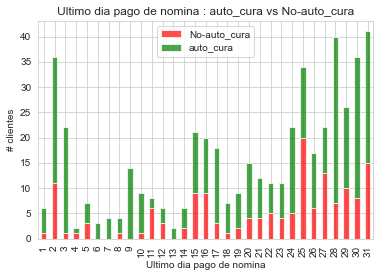

In [371]:
print('Ultimo dia pago de nomina en el mes anterior :')
#print(d_0.groupby(['dh_max_dia_otros_d','y_auto_cura']).y_auto_cura.count().unstack())
cic_class = d_0.groupby(['dh_max_dia_nomina_c','y_auto_cura']).y_auto_cura.count().unstack()
p1 = cic_class.plot(kind = 'bar', stacked = True, 
                   title = 'Ultimo dia pago de nomina : auto_cura vs No-auto_cura', 
                   color = ['red','green'], alpha = .70)
p1.set_xlabel('Ultimo dia pago de nomina')
p1.set_ylabel('# clientes')
p1.legend(['No-auto_cura','auto_cura'])
plt.show()

#### PERSPECTIVA:

* Se observa un gran número de clientes que reciben su pago de nómina en la segunda mitad del mes; posiblemente por que las empresas que pagan quincenal, paga a sus empleados la segunda quincena antes de que termine el mes y en estos clientes se evidencia una gran cantidad de clientes NO-auto_cura.


Ultimo dia de ingreso de dinero:
y_auto_cura             0     1
dh_max_dia_entradas            
1                       7     3
2                      13    19
3                       5     9
4                       5    12
5                      10    20
6                      12    17
7                       9    21
8                      22    24
9                      16    36
10                     23    30
11                     14    34
12                     39    48
13                     27    43
14                     48    54
15                     23    51
16                     40    60
17                     31    52
18                     28    47
19                     24    51
20                     43    70
21                     66    91
22                     69   103
23                     82   147
24                     90   154
25                     78   126
26                     89   133
27                    116   242
28                    461  1061
29     

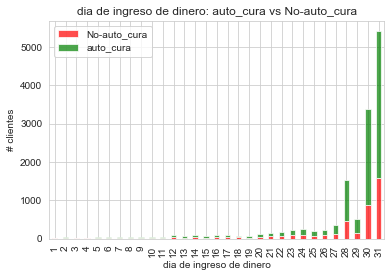

In [509]:
ses = train[train['dh_max_dia_entradas']!=0]
print('Ultimo dia de ingreso de dinero:')
print(ses.groupby(['dh_max_dia_entradas','y_auto_cura']).y_auto_cura.count().unstack())
pclass = ses.groupby(['dh_max_dia_entradas','y_auto_cura']).y_auto_cura.count().unstack()
p1 = pclass.plot(kind = 'bar', stacked = True, 
                   title = 'dia de ingreso de dinero: auto_cura vs No-auto_cura', 
                   color = ['red','green'], alpha = .70)
p1.set_xlabel('dia de ingreso de dinero')
p1.set_ylabel('# clientes')
p1.legend(['No-auto_cura','auto_cura'])
plt.show()

####  En contraste con lo inmediatamente anterior dicho, es claro que el ingreso de dinero de los clientes es mensual, pienso que las empresas pagan mensual de forma mensual.                                                                                                                                                          Estos clientes en gran proporción se auto curan, pero es de interés la cantidad de clientes que no se auto curan bajo esta caracteristica.


## Cuál es el día 0 ????
* En algunos variables que describen días se observa el dia 0, por ejemplo ```dh_min_dia_pagos_d``` que representa "Primer dia en el que realizó algún credito en el mes anterior"

      train['dh_min_dia_pagos_d'].unique()
    
      array([ 0, 13,  7,  2,  9,  8, 10,  1,  3,  5, 31,  4, 11, 20,  6, 30, 14,
       19, 24, 22, 17, 15, 16, 12, 18, 23, 27, 26, 21, 28, 25, 29],
      dtype=int64)

    queda la pregunta que representa este valor.

## SELECCIÓN DE VARIABLES

  ### Mantendré la variables que no esten altamente correlacionadas. 

In [389]:
correlations = train.corr().unstack().sort_values(kind="quicksort", ascending = False).reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations[correlations[0] != np.nan].head(50)

,level_0,level_1,0
30,gsm_mejor_gestion_3m,gsm_mejor_gestion,1.000000
50,gsm_mejor_gestion,gsm_mejor_gestion_3m,1.000000
58,dh_val_entradas,dmi_ingreso_total_mes,1.000000
70,cpc_sum_proc_deuda,cpc_avg_proc_deuda,1.000000
76,prom_mes_anterior,max_mes_anterior,1.000000
77,max_mes_anterior,prom_mes_anterior,1.000000
86,cpc_avg_proc_deuda,cpc_sum_proc_deuda,1.000000
92,dmi_ingreso_total_mes,dh_val_entradas,1.000000
112,dmi_egreso_total_mes,dh_val_salidas,0.999573
113,dh_val_salidas,dmi_egreso_total_mes,0.999573


In [ ]:
# función que encuentra factor de correlación entre variables  
def correlation(dataset, threshold):
    col_corr = set()  
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i] 
                col_corr.add(colname)
    return col_corr

* Se encuentran variables altamente correlacionadas 
###### Nota: Estos valores posiblemente se debe a la causalidad.

In [431]:
corr_features = correlation(train, 0.79)
print(f"Se encuentran {len(set(corr_features))} con alta correlación")

Se encuentran 50 con alta correlación


In [429]:
corr_features

{'cpc_avg_nro_cuota',
 'cpc_avg_saldo',
 'cpc_max_nro_cuota',
 'cpc_nro_cuota_tdc',
 'cpc_sum_proc_deuda',
 'dc_cant_obligaciones',
 'dc_max_saldo_sf',
 'dc_porc_prod_sin_mora',
 'dc_sum_valor_cuota',
 'dc_valobli_ing',
 'desv_sem',
 'desv_trim',
 'dh_avg_dia_pagos_d',
 'dh_avg_dia_retiros_d',
 'dh_avg_dia_salidas',
 'dh_cant_salidas',
 'dh_max_dia_comisio_d',
 'dh_max_dia_nomina_c',
 'dh_max_dia_pagos_d',
 'dh_max_dia_retiros_d',
 'dh_max_dia_salidas',
 'dh_val_retiros_d',
 'dh_val_salidas',
 'dmi_egreso_total_mes',
 'dmi_ingreso_total_mes',
 'dmi_max_ingreso_diario',
 'gsm_mejor_gestion_3m',
 'max_bim',
 'max_mes_anterior',
 'max_sem',
 'pc_cant_mora90_ult_12m_total',
 'pc_cant_moras_30_ult_3_meses',
 'pc_cant_moras_60_ult_12_meses',
 'pc_cant_moras_60_ult_3_meses',
 'pc_cant_moras_90_ult_12_meses',
 'pc_cantidad_tdc_entidad',
 'pc_cuota_de_consumo',
 'pc_gasto_familiar',
 'pc_ind_ajustado',
 'pc_ingreso_final',
 'pc_ingreso_por_rutina',
 'pc_ingreso_rutina_con_techo',
 'pc_productos

In [433]:
train.drop(corr_features,axis=1, inplace = True)
test.drop(corr_features,axis=1, inplace = True)

In [435]:
train.shape, test.shape

((20000, 54), (1000, 53))

### Para reducir aún más la dimensión del conjunto de datos utilizo```SelectKBest```
+ Voy a mantener 15 variables.

In [439]:
X = train.loc[:,train.columns != 'y_auto_cura']
y = train['y_auto_cura']

(20000, 53)

In [443]:
from sklearn.feature_selection import SelectFromModel, SelectKBest
select = SelectKBest(k = 15)
select_features = select.fit(X, y) 
indices_selected = select_features.get_support(indices = True)
colnames_selected = [X.columns[i] for i in indices_selected]

X_selected = X[colnames_selected]
test = test[colnames_selected]
X_selected.columns

Index(['max_trim', 'pc_cant_moras_30_ult_12_meses', 'desv_bim',
       'dh_cant_entradas', 'pc_transaccional', 'dh_val_entradas',
       'pcons_tarjeta_de_credito', 'cluster_recod', 'dh_cant_otros_d',
       'dh_cant_pagos_d', 'dh_max_dia_otros_d', 'marca_info_cifin_decode',
       'cpc_saldo_tdc', 'dh_cant_tras_d', 'dh_min_dia_entradas'],
      dtype='object')

#### Unimos por filas el ```test``` y ```train```

In [487]:
full_data = pd.concat([X_selected,test], 0, ignore_index=True)
full_data

,max_trim,pc_cant_moras_30_ult_12_meses,desv_bim,dh_cant_entradas,pc_transaccional,dh_val_entradas,pcons_tarjeta_de_credito,cluster_recod,dh_cant_otros_d,dh_cant_pagos_d,dh_max_dia_otros_d,marca_info_cifin_decode,cpc_saldo_tdc,dh_cant_tras_d,dh_min_dia_entradas
0,7,1.0,4.949747,0,3.000000e+06,0,0,13,0,0,0,2,0.0,0,0
1,17,1.0,7.071068,14,7.710300e+06,4452485,0,13,2,8,20,0,0.0,0,2
2,27,0.0,19.091883,5,6.670935e+06,3187600,0,13,2,1,27,0,0.0,0,7
3,27,1.0,19.091883,0,3.000000e+06,0,0,13,0,0,0,2,0.0,0,0
4,32,0.0,14.142136,2,3.150000e+06,1000000,0,13,0,4,0,0,0.0,0,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,0,0.0,0.000000,46,7.462140e+07,61033271,0,7,10,6,29,0,0.0,0,3
20996,4,0.0,2.828427,29,2.314231e+07,36525341,0,7,8,4,31,0,0.0,0,2
20997,2,0.0,1.414214,39,2.069115e+07,43528601,0,7,2,17,16,0,30468.0,9,2
20998,0,0.0,0.000000,78,2.069115e+07,129738616,0,7,4,21,17,0,35878.0,21,1


## PROCESAMIENTO DE LOS DATOS
* Encontrar y remover outliers en ```test``` y ```train```.

In [488]:
# Pequeña función para reemplazar outlier por el metodo rango intercuartil 
def Rem_outliers (df, name_col):
    q1 = df[name_col].quantile(0.25)
    q3 = df[name_col].quantile(0.75)
    riq = q3 - q1
    f_low = q1 - 1.5 * riq
    f_high = q3 + 1.5 * riq
    for i in  range(len(df[name_col])):  
        if (df[name_col][i] > f_high):
            df[name_col][i] = f_high
        elif (df[name_col][i] < f_low):
            df[name_col][i] = f_low    
    return df[name_col].describe()

In [489]:
# función para graficar boxplots
def plot_feature_boxplot(df,features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(3,5,figsize=(18,8))
    fig.subplots_adjust(hspace = .40)
    for feature in features:
        i += 1
        plt.subplot(3,5,i)
        plt.boxplot(df[feature])
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show()


<Figure size 432x288 with 0 Axes>

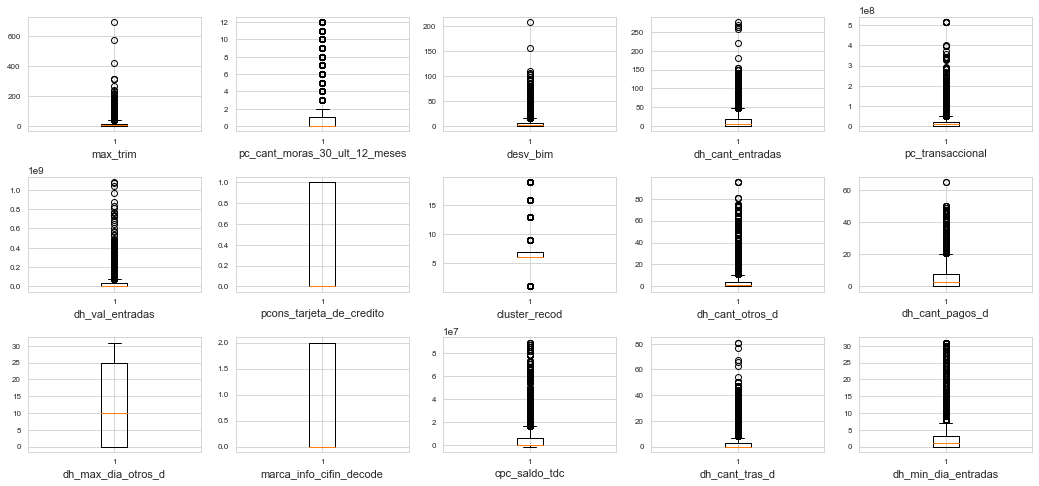

In [490]:
features = full_data.columns
plot_feature_boxplot(full_data, features)

* Eliminamos variables y volvemos a visualizar.

In [492]:
for i in full_data.columns:
    Rem_outliers(full_data,i)

<Figure size 432x288 with 0 Axes>

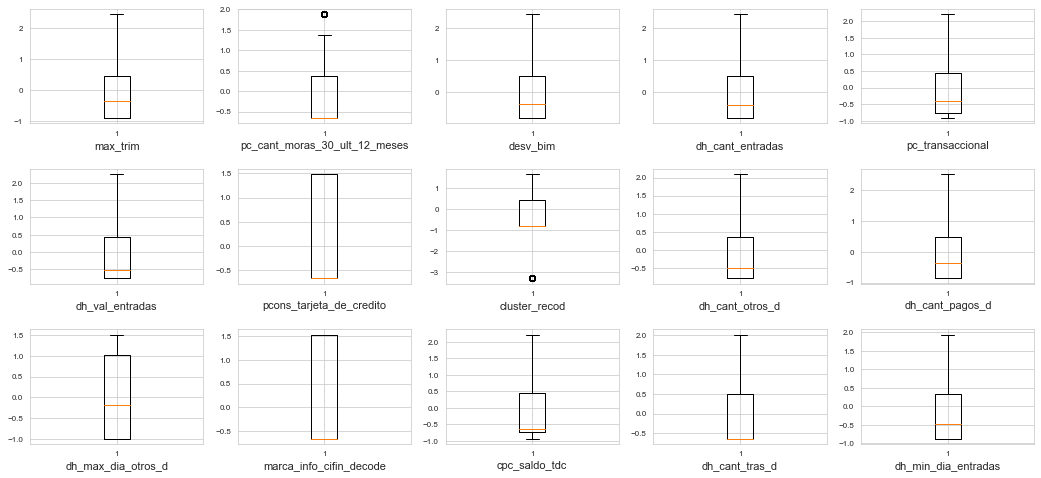

In [503]:
features = full_data.columns
plot_feature_boxplot(full_data, features)

### Escalamos los datos 

In [494]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(full_data)
full_data_es = pd.DataFrame(scaler.transform(full_data),columns = full_data.columns)
full_data_es

,max_trim,pc_cant_moras_30_ult_12_meses,desv_bim,dh_cant_entradas,pc_transaccional,dh_val_entradas,pcons_tarjeta_de_credito,cluster_recod,dh_cant_otros_d,dh_cant_pagos_d,dh_max_dia_otros_d,marca_info_cifin_decode,cpc_saldo_tdc,dh_cant_tras_d,dh_min_dia_entradas
0,-0.348733,0.357547,0.203892,-0.827401,-0.734177,-0.760902,-0.67491,1.668972,-0.785108,-0.862815,-0.984469,1.538552,-0.732234,-0.641482,-0.872388
1,0.450284,0.357547,0.635395,0.145767,-0.445160,-0.594184,-0.67491,1.668972,-0.210118,0.490620,0.623778,-0.662899,-0.732234,-0.641482,-0.068379
2,1.249300,-0.660346,2.433326,-0.479841,-0.508934,-0.641546,-0.67491,1.668972,-0.210118,-0.693635,1.186664,-0.662899,-0.732234,-0.641482,1.941643
3,1.249300,0.357547,2.433326,-0.827401,-0.734177,-0.760902,-0.67491,1.668972,-0.785108,-0.862815,-0.984469,1.538552,-0.732234,-0.641482,-0.872388
4,1.648808,-0.660346,2.073740,-0.688377,-0.724973,-0.723458,-0.67491,1.668972,-0.785108,-0.186097,-0.984469,-0.662899,-0.732234,-0.641482,1.941643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,-0.908044,-0.660346,-0.802949,2.370149,2.208884,1.524418,-0.67491,0.429899,2.089843,0.152261,1.347488,-0.662899,-0.732234,-0.641482,0.333625
20996,-0.588437,-0.660346,-0.227611,1.188446,0.501725,0.606747,-0.67491,0.429899,1.514853,-0.186097,1.508313,-0.662899,-0.732234,-0.641482,-0.068379
20997,-0.748241,-0.660346,-0.515280,1.883566,0.351326,0.868976,-0.67491,0.429899,-0.210118,2.013235,0.302128,-0.662899,-0.726778,2.022977,-0.068379
20998,-0.908044,-0.660346,-0.802949,2.439661,0.351326,2.243911,-0.67491,0.429899,0.364872,2.520773,0.382541,-0.662899,-0.725809,2.022977,-0.470383


In [496]:
test_es = full_data_es[len(y):]
train_es = full_data_es[:len(y)]

In [514]:
print(f"X_resampled1 :{sorted(Counter(y_resampled1).items())}")

Desbalance etiqueta de objetivo:[(0, 6152), (1, 13848)]


### Anteriormente en el análisis de objetivo se observó que este presenta un desbalanceo de clase, tratemos este inconveniente.

In [518]:
print(f"Sin remuestrear:{sorted(Counter(y).items())}")
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(train_es, y)
print(f"X_resampled: {sorted(Counter(y_resampled).items())}")
X_resampled = pd.DataFrame(X_resampled, columns=train_es.columns)

from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=0)
X_resampled1, y_resampled1 = smote_tomek.fit_resample(train_es, y)
print(f"X_resampled1 :{sorted(Counter(y_resampled1).items())}")
X_resampled1 = pd.DataFrame(X_resampled1, columns=train_es.columns)

#pip install imblearn
from imblearn.over_sampling import ADASYN 

ada = ADASYN(random_state=42, sampling_strategy = 1)
X_resampled2, y_resampled2 = ada.fit_resample(train_es, y)
print('X_resampled2 : %s' % Counter(y_resampled2))
X_resampled2 = pd.DataFrame(X_resampled2, columns=train_es.columns)



Desbalance etiqueta de objetivo:[(0, 6152), (1, 13848)]
X_resampled: [(0, 8956), (1, 6837)]
X_resampled1 :[(0, 13240), (1, 13240)]
X_resampled2 : Counter({1: 13848, 0: 12838})


,max_trim,pc_cant_moras_30_ult_12_meses,desv_bim,dh_cant_entradas,pc_transaccional,dh_val_entradas,pcons_tarjeta_de_credito,cluster_recod,dh_cant_otros_d,dh_cant_pagos_d,dh_max_dia_otros_d,marca_info_cifin_decode,cpc_saldo_tdc,dh_cant_tras_d,dh_min_dia_entradas
0,-0.348733,0.357547,0.203892,-0.827401,-0.734177,-0.760902,-0.67491,1.668972,-0.785108,-0.862815,-0.984469,1.538552,-0.732234,-0.641482,-0.872388
1,0.450284,0.357547,0.635395,0.145767,-0.445160,-0.594184,-0.67491,1.668972,-0.210118,0.490620,0.623778,-0.662899,-0.732234,-0.641482,-0.068379
2,1.249300,-0.660346,2.433326,-0.479841,-0.508934,-0.641546,-0.67491,1.668972,-0.210118,-0.693635,1.186664,-0.662899,-0.732234,-0.641482,1.941643
3,1.249300,0.357547,2.433326,-0.827401,-0.734177,-0.760902,-0.67491,1.668972,-0.785108,-0.862815,-0.984469,1.538552,-0.732234,-0.641482,-0.872388
4,1.648808,-0.660346,2.073740,-0.688377,-0.724973,-0.723458,-0.67491,1.668972,-0.785108,-0.186097,-0.984469,-0.662899,-0.732234,-0.641482,1.941643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26681,-0.908044,-0.660346,-0.802949,-0.827401,-0.837546,-0.760902,1.48168,0.429899,-0.785108,-0.862815,-0.984469,-0.662899,-0.716727,-0.641482,-0.872388
26682,-0.908044,-0.660346,-0.802949,-0.827401,-0.827404,-0.760902,1.48168,0.429899,-0.785108,-0.862815,-0.984469,-0.662899,-0.732234,-0.641482,-0.872388
26683,-0.764274,-0.049833,-0.802949,0.173587,0.551650,0.721584,-0.67491,-0.809173,0.594680,2.249937,0.881150,-0.662899,1.183698,0.043414,-0.068379
26684,-0.090588,0.357547,-0.000795,0.068234,0.125575,0.569189,-0.67491,-0.809173,1.636486,0.848500,0.518623,-0.662899,2.221101,1.042105,-0.470383


## Modelado predictivo
* Ahora predeciremos si el cliente se auto curará o no usando algunos algoritmos de clasificación. A continuación se muestran los algoritmos que usaré para hacer el modelo:

    * Logistic Regression

    * Support Vector Machines(Linear and radial)

    * Random Forest

    * K-Nearest Neighbours

    * Naive Bayes

    * Decision Tree

    * Logistic Regression
    
 ### Nota: Se prueban los modelos en crudo antes mencionados para luego escoger el de mejor rendimiento. 
    

In [520]:
from sklearn.linear_model import LogisticRegression 
from sklearn import svm 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split  as tts

In [522]:
X_train, X_test, y_train, y_test = tts(train_es, y,  test_size=0.2,random_state=0)
X_train_es, X_test_es, y_train_es, y_test_es = tts(X_resampled, y_resampled,  test_size=0.2,random_state=1)
X_train1, X_test1, y_train1, y_test1 = tts(X_resampled1, y_resampled1,  test_size=0.2,random_state=2)
X_train2, X_test2, y_train2, y_test2 = tts(X_resampled2, y_resampled2,  test_size=0.2,random_state=3)

In [523]:
svm_rbf =svm.SVC(kernel='rbf',C=1,gamma=0.1, probability=True)
svm_linear =svm.SVC(kernel='linear',C=0.1,gamma=0.1,probability=True)
loreg = LogisticRegression()
tree = DecisionTreeClassifier()
knn = KNeighborsClassifier() 
gnb = GaussianNB()
rfc = RandomForestClassifier(n_estimators=100)


### Pruebas con ```train_es``` para todos los modelos.
+ Recordemos el balance:

            train_es : Counter({1: 13848, 0: 6156})
            

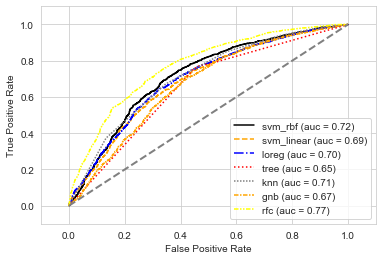

In [529]:
all_clf = [svm_rbf, svm_linear, loreg, tree, knn, gnb, rfc]
clf_labels = ['svm_rbf','svm_linear', 'loreg', 'tree','knn', 'gnb', 'rfc']

colors = ['black', 'orange', 'blue', 'red', 'gray', 'orange', 'yellow']
linestyles = ['-', '--', '-.', ':', (0, (1, 1)), (0, (3, 1, 1, 1)),(0, (3, 1, 1, 1, 1, 1))]
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train,y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,color=clr,linestyle=ls,
           label='%s (auc = %0.3f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--',
         color='gray',linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
#plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

#### ```rfc``` presenta mejor rendimiento (0.77), sigamos probando...

### Pruebas con ```X_resampled``` para todos los modelos.
+ Recordemos el balance:

         X_resampled : Counter({1: 6387, 0: 8956})

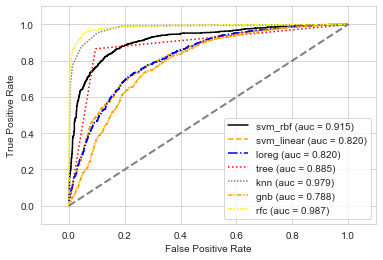

In [530]:
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train_es,y_train_es).predict_proba(X_test_es)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test_es,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,color=clr,linestyle=ls,
           label='%s (auc = %0.3f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--',
         color='gray',linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
#plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

#### Nuevamente  ```rfc```  presenta mejor rendimiento (0.987), sigamos probando...

### Pruebas con ```X_resampled1``` para todos los modelos.
+ Recordemos el balance:

        X_resampled1 : Counter({1: 13240, 0: 13240})

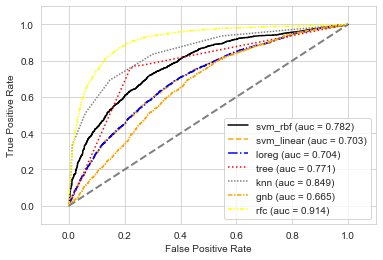

In [531]:
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train1,y_train1).predict_proba(X_test1)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test1,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,color=clr,linestyle=ls,
           label='%s (auc = %0.3f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--',
         color='gray',linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
#plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

#### Nuevamente  ```rfc```  presenta mejor rendimiento (0.914), sigamos probando...

### Pruebas con ```X_resampled2``` para todos los modelos.
+ Recordemos el balance:

        X_resampled2 : Counter({1: 13848, 0: 12838})

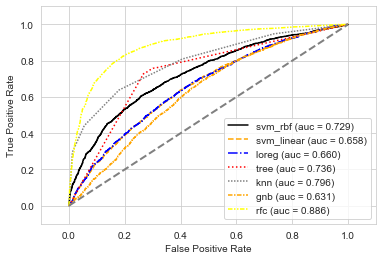

In [532]:
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train2,y_train2).predict_proba(X_test2)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test2,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,color=clr,linestyle=ls,
           label='%s (auc = %0.3f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--',
         color='gray',linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
#plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

#### ```rfc``` presenta mejor rendimiento (0.886), sigamos probando...

### Conclusiones del entrenamiento de modelos:
* En todas las pruebas ```rfc``` obtuvo la mejor puntuación, recordemos esa metrica de puntuación (auc)
* En el conjunto de datos sin remuestreo los resultados no fueron buenos.
* Parece haber sobre ajuste en el entrenamiento con ```X_resampled1``` 
* ```X_resampled1```  presentá indicios de que no hay sobreajuste.


## Validación cruzada

In [537]:
kfold = KFold(n_splits=5) 
xyz = []
auc = []
std = []
classifiers = ['svm_rbf','svm_linear', 'loreg', 'tree','knn', 'gnb', 'rfc']
models = [svm_rbf, svm_linear, loreg, tree, knn, gnb, rfc]
for i in models:
    model = i
    cv_result = cross_val_score(model,X_train1,y_train1, cv = kfold,scoring = "roc_auc")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    auc.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2

KeyboardInterrupt: 

### Puesto que  ```rfc``` obtuvo un buena evaluación, realizamos una selección de caracteristicas con base en el modelo utilizando la función ```SBS``` definida al principio del cuaderno con el fin de tratar un sobreajuste.

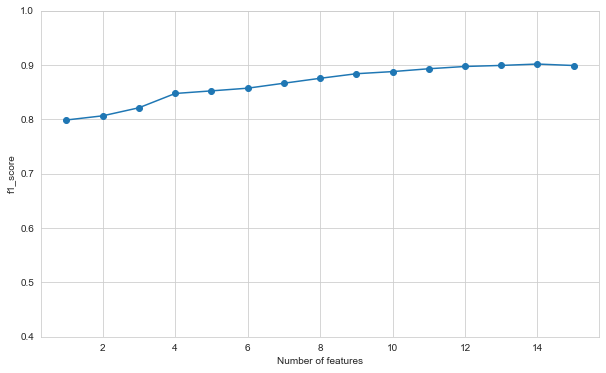

In [584]:
sbs = SBS(rfc , k_features=1)
sbs.fit(X_train1, y_train1)
k_feat = [len(k) for k in sbs.subsets_]
plt.figure(figsize=(10,6))
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.4, 1])
plt.ylabel('auc_score')
plt.xlabel('Number of features')
#plt.grid()
plt.show()

##### Obs: 
* La elección de el número de variables es cuando la gráfica empieza a crecer por primera vez, en este caso 8, el indice se obtiene  contando desde cero hasta el 8 que sería 7.

In [565]:
# N_var_indice: numero de variables dependiendo de SBS

In [651]:
# función 
def general_report (N_var_indice,model,train_X,train_y,test_X, test_y):
    print("======================")
    k = list(sbs.subsets_[N_var_indice])
    print(f"Variables seccionadas:\n {train_X.columns[k]}")
    y_pred = model.fit(train_X.iloc[:,k],train_y).predict_proba(test_X.iloc[:,k])[:,1]
    fpr, tpr, thresholds = roc_curve(y_true=test_y,y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    print("======================")
    print(f"AUC: {roc_auc}")
    print("====================== ")
    cm = confusion_matrix(test_y, model.predict(test_X.iloc[:,k]))  
    print ("Confusion Matrix :\n", cm)    
    print("====================== ")
    print("Reporte de clasificación:")
    print(classification_report(test_y, model.predict(test_X.iloc[:,k])))
    scores_auc_test= cross_val_score(model, test_X.iloc[:,k], test_y, cv=3, scoring = 'roc_auc' )
    scores_auc_train = cross_val_score(model, train_X.iloc[:,k], train_y, cv=3, scoring = 'roc_auc')
    print("====================== ")
    print('cross_val_test:',scores_auc_test.mean())
    print('cross_val_train:',scores_auc_train.mean())
    print("====================== ")
    return print("Proceso Completo")

In [585]:
general_report(7,rfc, X_train1, y_train1,X_test1, y_test1)

Variables seccionadas:
 Index(['max_trim', 'pc_cant_moras_30_ult_12_meses', 'desv_bim',
       'dh_cant_entradas', 'pc_transaccional', 'dh_val_entradas',
       'cluster_recod', 'marca_info_cifin_decode'],
      dtype='object')
AUC: 0.8829262551014075
Confusion Matrix :
 [[2073  522]
 [ 503 2198]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      2595
           1       0.81      0.81      0.81      2701

    accuracy                           0.81      5296
   macro avg       0.81      0.81      0.81      5296
weighted avg       0.81      0.81      0.81      5296

rfc_best_test: 0.7934841122575248
rfc_best_train: 0.8724354315572838
Proceso Completo


## Metodos de ensamble
* El ensamble es una buena forma de aumentar la precisión o el rendimiento de un modelo. En palabras simples, es la combinación de varios modelos simples para crear un único modelo poderoso.

### Voting Classifier

In [592]:
from sklearn.ensemble import VotingClassifier
vot_clas = VotingClassifier(estimators=[('knn',knn),
                                              ('svm_rbf',svm_rbf),
                                              ('rfc',rfc),
                                              ('loreg',loreg),
                                              ('tree',tree),
                                              ('gnb',gnb),
                                              ('svm_linear',svm_linear)],
                                  voting='soft')
general_report(7,vot_clas, X_train1, y_train1,X_test1, y_test1)

Variables seccionadas:
 Index(['max_trim', 'pc_cant_moras_30_ult_12_meses', 'desv_bim',
       'dh_cant_entradas', 'pc_transaccional', 'dh_val_entradas',
       'cluster_recod', 'marca_info_cifin_decode'],
      dtype='object')
AUC: 0.8384362032473522
Confusion Matrix :
 [[1959  636]
 [ 582 2119]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      2595
           1       0.77      0.78      0.78      2701

    accuracy                           0.77      5296
   macro avg       0.77      0.77      0.77      5296
weighted avg       0.77      0.77      0.77      5296

rfc_best_test: 0.765302504289323
rfc_best_train: 0.8292614173850128
Proceso Completo


### Bagging

In [593]:
from sklearn.ensemble import BaggingClassifier
bgc = BaggingClassifier(base_estimator=rfc)
general_report(7,bgc, X_train1, y_train1,X_test1, y_test1)

Variables seccionadas:
 Index(['max_trim', 'pc_cant_moras_30_ult_12_meses', 'desv_bim',
       'dh_cant_entradas', 'pc_transaccional', 'dh_val_entradas',
       'cluster_recod', 'marca_info_cifin_decode'],
      dtype='object')
AUC: 0.8815920600305747
Confusion Matrix :
 [[2061  534]
 [ 489 2212]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      2595
           1       0.81      0.82      0.81      2701

    accuracy                           0.81      5296
   macro avg       0.81      0.81      0.81      5296
weighted avg       0.81      0.81      0.81      5296

rfc_best_test: 0.7912675660427807
rfc_best_train: 0.8674780491038871
Proceso Completo


### AdaBoost(Adaptive Boosting)

In [594]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100)
general_report(7,ada, X_train1, y_train1,X_test1, y_test1)

Variables seccionadas:
 Index(['max_trim', 'pc_cant_moras_30_ult_12_meses', 'desv_bim',
       'dh_cant_entradas', 'pc_transaccional', 'dh_val_entradas',
       'cluster_recod', 'marca_info_cifin_decode'],
      dtype='object')
AUC: 0.7537514472267819
Confusion Matrix :
 [[1655  940]
 [ 687 2014]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.71      0.64      0.67      2595
           1       0.68      0.75      0.71      2701

    accuracy                           0.69      5296
   macro avg       0.69      0.69      0.69      5296
weighted avg       0.69      0.69      0.69      5296

rfc_best_test: 0.7487517327783694
rfc_best_train: 0.7514795088942676
Proceso Completo


### Stochastic Gradient Boosting

In [595]:
from sklearn.ensemble import GradientBoostingClassifier
grad = GradientBoostingClassifier(n_estimators=500,random_state=0,learning_rate=0.1)
general_report(7,grad, X_train1, y_train1,X_test1, y_test1)

Variables seccionadas:
 Index(['max_trim', 'pc_cant_moras_30_ult_12_meses', 'desv_bim',
       'dh_cant_entradas', 'pc_transaccional', 'dh_val_entradas',
       'cluster_recod', 'marca_info_cifin_decode'],
      dtype='object')
AUC: 0.8688613151911908
Confusion Matrix :
 [[1857  738]
 [ 404 2297]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.82      0.72      0.76      2595
           1       0.76      0.85      0.80      2701

    accuracy                           0.78      5296
   macro avg       0.79      0.78      0.78      5296
weighted avg       0.79      0.78      0.78      5296

rfc_best_test: 0.8305315944410214
rfc_best_train: 0.8618373186382021
Proceso Completo


### xgboost

In [596]:
from xgboost import XGBClassifier
xgbc = XGBClassifier(booster='gbtree', objective='binary:logistic', 
                     max_depth = 8,learning_rate = 0.1,
                     n_estimators = 150, n_jobs = -1,
                     random_state = 2, verbosity=0,)
general_report(7,xgbc, X_train1, y_train1,X_test1, y_test1)

Variables seccionadas:
 Index(['max_trim', 'pc_cant_moras_30_ult_12_meses', 'desv_bim',
       'dh_cant_entradas', 'pc_transaccional', 'dh_val_entradas',
       'cluster_recod', 'marca_info_cifin_decode'],
      dtype='object')
AUC: 0.8909924177087056
Confusion Matrix :
 [[1969  626]
 [ 360 2341]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.85      0.76      0.80      2595
           1       0.79      0.87      0.83      2701

    accuracy                           0.81      5296
   macro avg       0.82      0.81      0.81      5296
weighted avg       0.82      0.81      0.81      5296

rfc_best_test: 0.8322955130257315
rfc_best_train: 0.8820040817930579
Proceso Completo


### RUSBoostClassifier

In [597]:
from imblearn.ensemble import RUSBoostClassifier
rusb = RUSBoostClassifier(n_estimators = 290, learning_rate= 1.7,random_state=0)
general_report(7,rusb, X_train1, y_train1,X_test1, y_test1)

Variables seccionadas:
 Index(['max_trim', 'pc_cant_moras_30_ult_12_meses', 'desv_bim',
       'dh_cant_entradas', 'pc_transaccional', 'dh_val_entradas',
       'cluster_recod', 'marca_info_cifin_decode'],
      dtype='object')
AUC: 0.8181184589451277
Confusion Matrix :
 [[1719  876]
 [ 520 2181]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.77      0.66      0.71      2595
           1       0.71      0.81      0.76      2701

    accuracy                           0.74      5296
   macro avg       0.74      0.73      0.73      5296
weighted avg       0.74      0.74      0.73      5296

rfc_best_test: 0.7949445715379422
rfc_best_train: 0.8174478318447417
Proceso Completo


### lightgbm

In [598]:
from lightgbm import LGBMClassifier
lgbc = LGBMClassifier(max_depth = -1,n_estimators=150)
general_report(7,lgbc, X_train1, y_train1,X_test1, y_test1)

Variables seccionadas:
 Index(['max_trim', 'pc_cant_moras_30_ult_12_meses', 'desv_bim',
       'dh_cant_entradas', 'pc_transaccional', 'dh_val_entradas',
       'cluster_recod', 'marca_info_cifin_decode'],
      dtype='object')
AUC: 0.8814304842493931
Confusion Matrix :
 [[1952  643]
 [ 416 2285]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.82      0.75      0.79      2595
           1       0.78      0.85      0.81      2701

    accuracy                           0.80      5296
   macro avg       0.80      0.80      0.80      5296
weighted avg       0.80      0.80      0.80      5296

rfc_best_test: 0.8274693118998426
rfc_best_train: 0.8731095007174989
Proceso Completo


In [652]:
from sklearn.ensemble import VotingClassifier
vot_clas_ensem = VotingClassifier(estimators=[('lgbc',lgbc),
                                              ('xgbc',xgbc),
                                              ('bgc',bgc),],voting='soft')
general_report(7,vot_clas_ensem, X_train1, y_train1,X_test1, y_test1)

Variables seccionadas:
 Index(['max_trim', 'pc_cant_moras_30_ult_12_meses', 'desv_bim',
       'dh_cant_entradas', 'pc_transaccional', 'dh_val_entradas',
       'cluster_recod', 'marca_info_cifin_decode'],
      dtype='object')
AUC: 0.8999698249203356
Confusion Matrix :
 [[2018  577]
 [ 386 2315]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      2595
           1       0.80      0.86      0.83      2701

    accuracy                           0.82      5296
   macro avg       0.82      0.82      0.82      5296
weighted avg       0.82      0.82      0.82      5296

cross_val_test: 0.8219342194773475
cross_val_train: 0.8846570766275703
Proceso Completo


### El modelo ```vot_clas_ensem``` por ensamble obtuvo una mejor puntuación **(0.89)** de todos los modelos entrenados con este metodo.
* Con este modelo  realizamos nuevas pruebas con los demas conjuntos de entrenamiento tratando de encontrar mejores resultados. 

## Genero la predicción final del conjunto  prueba y genero el archivo.csv

In [754]:
submission = pd.DataFrame({'llave': llave_test,
                           'probabilidad': vot_clas_ensem.predict_proba(test_es.iloc[:,k])[:,1]})
submission.to_csv('Base_prueba_evaluado.csv', index=False)
submission

,llave,probabilidad
0,1,0.737501
1,3,0.760421
2,4,0.730812
3,6,0.851474
4,7,0.847200
...,...,...
995,2019,0.842665
996,2021,0.872612
997,2025,0.598129
998,2027,0.407936


### Variables Importantes

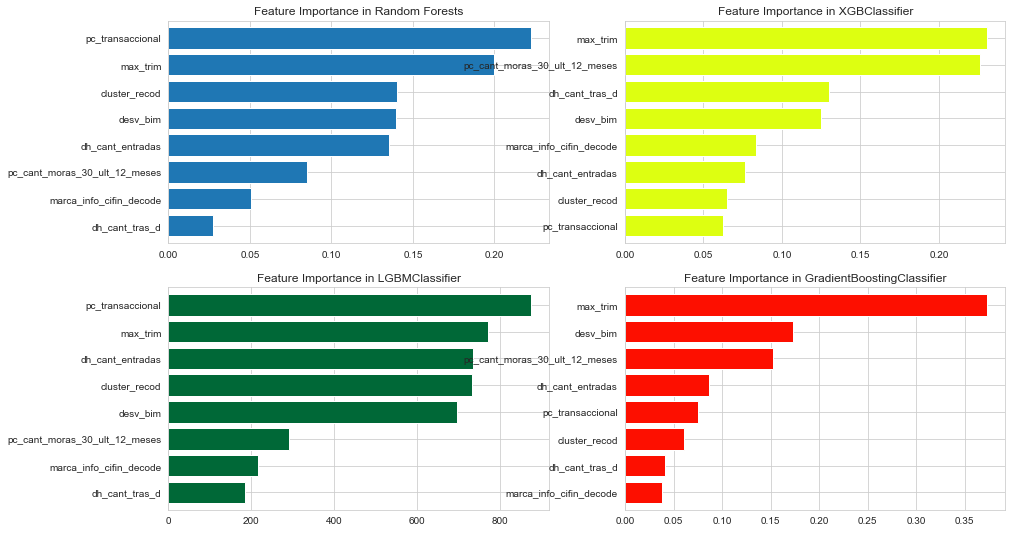

In [696]:
f,ax=plt.subplots(2,2,figsize=(15,9))
pd.Series(rfc.feature_importances_,X_test1.iloc[:,k].columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,0])
ax[0,0].set_title('Feature Importance in Random Forests')
pd.Series(xgbc.feature_importances_,X_test1.iloc[:,k].columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,1],color='#ddff11')
ax[0,1].set_title('Feature Importance in XGBClassifier')
pd.Series(lgbc.feature_importances_,X_test1.iloc[:,k].columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,0],cmap='RdYlGn_r')
ax[1,0].set_title('Feature Importance in LGBMClassifier')
pd.Series(grad.feature_importances_,X_test1.iloc[:,k].columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,1],color='#FD0F00')
ax[1,1].set_title('Feature Importance in GradientBoostingClassifier')
plt.show()

### Perspectiva:
* La variable ```max_trim``` y  ```desv_bim``` está en común en los modelos .
* ```pc_transaccional```esta como de primera importancia en ```LGBMClassifier``` y ```RandomForestClassifier```, contrasta si se tiene en cuenta que ```XGBClassifier``` está basado en arboles de desición.
